In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv('NYC_subway_traffic_2017-2021.csv')
new_df = df.copy()
new_df = new_df[['Unique ID','Datetime','Structure','Borough','Neighborhood','Entries','Exits']]
new_df['Datetime'] = pd.to_datetime(new_df['Datetime'])
new_df['Datetime_formatted'] = new_df['Datetime'].dt.strftime('%Y-%m-%d %H')
new_df['Datetime_formatted'] = pd.to_datetime(new_df['Datetime_formatted'])
# new_df.drop(columns=['Datetime'], inplace=True)
new_df['Year'] = new_df['Datetime_formatted'].dt.year
new_df['Month'] = new_df['Datetime_formatted'].dt.month
new_df['Day'] = new_df['Datetime_formatted'].dt.day
new_df['Hour'] = new_df['Datetime_formatted'].dt.hour

filtered_df = new_df.copy()
filtered_df.drop(columns=['Datetime'], inplace=True)
# Aggregate to daily total traffic
filtered_df['Total'] = filtered_df['Entries'] + filtered_df['Exits']
filtered_df['Netflow'] = filtered_df['Entries'] - filtered_df['Exits']

grouped_df = filtered_df.groupby(['Year', 'Month', 'Day','Borough']).agg({'Total': 'sum', 'Netflow': 'mean'}).reset_index()



In [18]:
def filter_by_borough(df, borough):
    filtered_df = df[df['Borough'] == borough].copy()
    filtered_df.reset_index(drop=True, inplace=True)
    return filtered_df
M = filter_by_borough(grouped_df, 'M')
M

Year  Month  Day Borough      Total     Netflow
0     2017      2    4       M  2616185.0  229.856346
1     2017      2    5       M  2266147.0  205.503099
2     2017      2    6       M  5014043.0  558.565900
3     2017      2    7       M  5217486.0  596.048319
4     2017      2    8       M  5388431.0  640.087185
...    ...    ...  ...     ...        ...         ...
1647  2021      8    9       M  1869327.0 -203.023810
1648  2021      8   10       M  1999689.0 -227.839378
1649  2021      8   11       M  2023781.0 -233.853734
1650  2021      8   12       M  2000816.0 -240.491192
1651  2021      8   13       M  1515012.0 -290.258940

[1652 rows x 6 columns]

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction(df):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Netflow']
    Train on the first week of data, then predict daily in a rolling manner.
    """
    df = df.copy()

    # Create datetime column and sort
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)

    # Create numeric day index
    start_date = df['Date'].min()
    df['day_index'] = (df['Date'] - start_date).dt.days

    # Define the first week (7 days) of training data
    first_week_end = start_date + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    # Prepare containers for predictions and actuals
    predictions_total = []
    predictions_netflow = []
    actual_total = []
    actual_netflow = []
    prediction_dates = []

    # Rolling daily prediction
    for i, row in test_data.iterrows():
        X_test = [[row['day_index']]]

        # Train models
        model_total = LinearRegression().fit(train_data[['day_index']], train_data['Total'])
        model_netflow = LinearRegression().fit(train_data[['day_index']], train_data['Netflow'])

        # Predict
        total_pred = model_total.predict(X_test)[0]
        netflow_pred = model_netflow.predict(X_test)[0]

        # Store predictions
        predictions_total.append(total_pred)
        predictions_netflow.append(netflow_pred)
        actual_total.append(row['Total'])
        actual_netflow.append(row['Netflow'])
        prediction_dates.append(row['Date'])

        # Add current day to training set
        new_row = pd.DataFrame({
            'day_index': [row['day_index']],
            'Total': [row['Total']],
            'Netflow': [row['Netflow']]
        })
        train_data = pd.concat([train_data, new_row], ignore_index=True)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow,
    })

    # Calculate RMSE
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"Rolling Daily Prediction Total RMSE: {total_rmse:.2f}")
    print(f"Rolling Daily Prediction Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/D

Rolling Daily Prediction Total RMSE: 2046342254786.24
Rolling Daily Prediction Netflow RMSE: 31870.12
        Date  Predicted_Total  Actual_Total  Predicted_Netflow  Actual_Netflow
0 2017-02-11     5.508034e+06     3070505.0         619.811226      286.336439
1 2017-02-12     4.638637e+06     2135407.0         497.798715      192.021830
2 2017-02-13     3.672330e+06     5033368.0         378.833194      565.662827
3 2017-02-14     4.196103e+06     5431280.0         450.115238      627.966457
4 2017-02-15     4.698855e+06     5389501.0         521.529307      627.490586


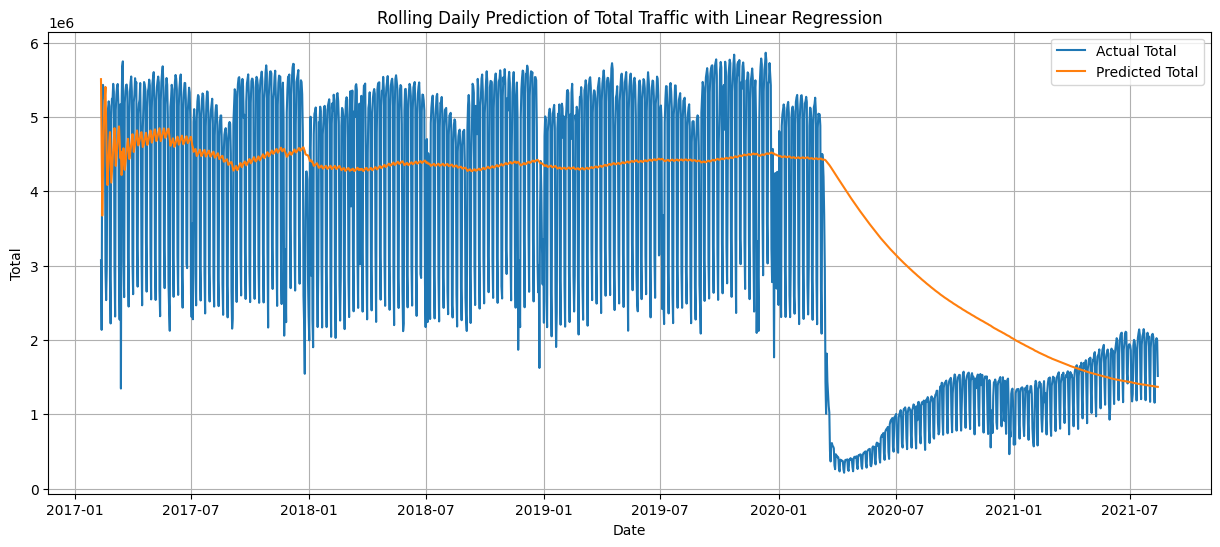

In [20]:
import matplotlib.pyplot as plt
results1 = rolling_daily_prediction(M)
print(results1.head())

# Plot example

plt.figure(figsize=(15,6))
plt.plot(results1['Date'], results1['Actual_Total'], label='Actual Total')
plt.plot(results1['Date'], results1['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def rolling_daily_prediction_svr(df):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Netflow']
    Uses SVR instead of Linear Regression.
    Trains on the first week, then predicts daily in a rolling fashion.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)
    df['day_index'] = (df['Date'] - df['Date'].min()).dt.days

    # Train on first 7 days
    first_week_end = df['Date'].min() + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    # Scale features for SVR
    scaler_X = StandardScaler()
    scaler_y_total = StandardScaler()
    scaler_y_netflow = StandardScaler()

    predictions_total = []
    predictions_netflow = []
    actual_total = []
    actual_netflow = []
    prediction_dates = []

    for i, row in test_data.iterrows():
        # Fit scalers on current training set
        X_train = train_data[['day_index']].values
        y_train_total = train_data['Total'].values.reshape(-1, 1)
        y_train_netflow = train_data['Netflow'].values.reshape(-1, 1)

        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_total_scaled = scaler_y_total.fit_transform(y_train_total).ravel()
        y_train_netflow_scaled = scaler_y_netflow.fit_transform(y_train_netflow).ravel()

        # Train SVR models
        model_total = SVR(kernel='rbf', C=100, epsilon=0.1)
        model_netflow = SVR(kernel='rbf', C=100, epsilon=0.1)

        model_total.fit(X_train_scaled, y_train_total_scaled)
        model_netflow.fit(X_train_scaled, y_train_netflow_scaled)

        # Predict
        X_test = [[row['day_index']]]
        X_test_scaled = scaler_X.transform(X_test)

        total_pred_scaled = model_total.predict(X_test_scaled)
        netflow_pred_scaled = model_netflow.predict(X_test_scaled)

        total_pred = scaler_y_total.inverse_transform(total_pred_scaled.reshape(-1, 1))[0][0]
        netflow_pred = scaler_y_netflow.inverse_transform(netflow_pred_scaled.reshape(-1, 1))[0][0]

        # Store results
        predictions_total.append(total_pred)
        predictions_netflow.append(netflow_pred)
        actual_total.append(row['Total'])
        actual_netflow.append(row['Netflow'])
        prediction_dates.append(row['Date'])

        # Add row to training set
        new_row = pd.DataFrame({
            'day_index': [row['day_index']],
            'Total': [row['Total']],
            'Netflow': [row['Netflow']]
        })
        train_data = pd.concat([train_data, new_row], ignore_index=True)

    # Results
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow,
    })

    # RMSE (using root mean squared error for readability)
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"SVR Daily Prediction Total RMSE: {total_rmse:.2f}")
    print(f"SVR Daily Prediction Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


SVR Daily Prediction Total RMSE: 1666201320048.86
SVR Daily Prediction Netflow RMSE: 26904.15
         Date  Predicted_Total  Actual_Total  Predicted_Netflow  \
0  2017-02-11     1.044395e+07     3070505.0        1251.035308   
1  2017-02-12    -1.263241e+06     2135407.0        -270.516358   
2  2017-02-13     3.192137e+06     5033368.0         346.030177   
3  2017-02-14     9.252326e+06     5431280.0        1080.698580   
4  2017-02-15     4.854735e+06     5389501.0         564.408924   
..        ...              ...           ...                ...   
95 2017-05-17     5.351575e+06     5597936.0         616.547937   
96 2017-05-18     5.382230e+06     5680973.0         645.125582   
97 2017-05-19     5.579272e+06     5462994.0         682.719020   
98 2017-05-20     5.642404e+06     3216882.0         657.908046   
99 2017-05-21     5.340964e+06     2696423.0         645.737987   

    Actual_Netflow  
0       286.336439  
1       192.021830  
2       565.662827  
3       627.96645

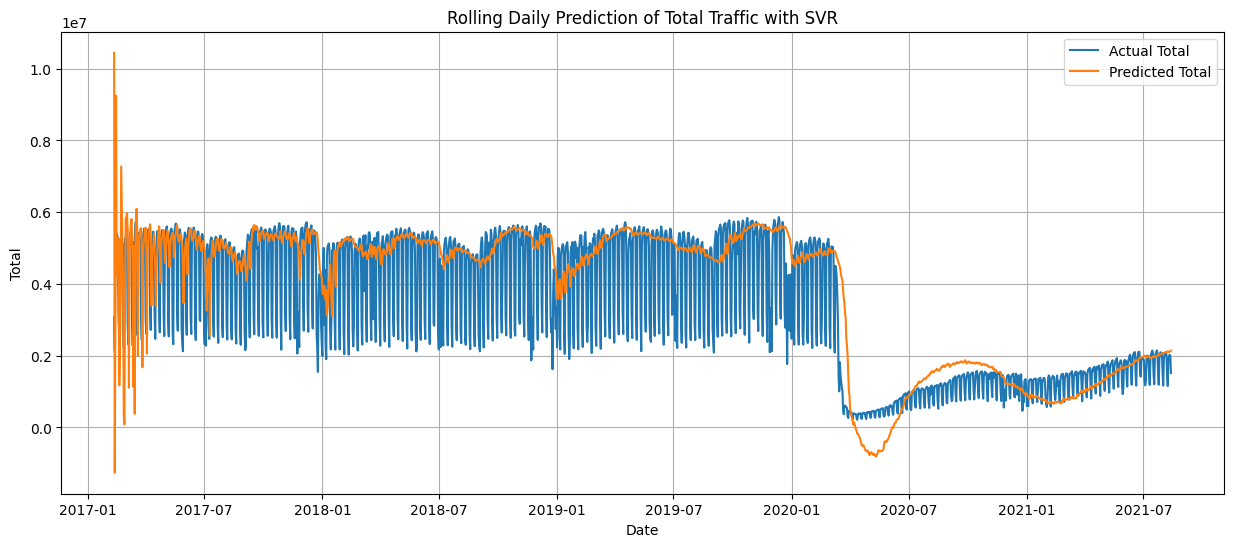

In [22]:
results2 = rolling_daily_prediction_svr(M)
print(results2.head(100))

# Plot example

plt.figure(figsize=(15,6))
plt.plot(results2['Date'], results2['Actual_Total'], label='Actual Total')
plt.plot(results2['Date'], results2['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with SVR')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction_rf(df):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Netflow']
    Trains on first 7 days, then predicts daily using RandomForestRegressor.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)
    df['day_index'] = (df['Date'] - df['Date'].min()).dt.days

    # Add basic temporal features
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Train on first week
    first_week_end = df['Date'].min() + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    # Feature columns
    feature_cols = ['day_index', 'day_of_week', 'is_weekend']

    # Storage
    predictions_total = []
    predictions_netflow = []
    actual_total = []
    actual_netflow = []
    prediction_dates = []

    for _, row in test_data.iterrows():
        X_train = train_data[feature_cols]
        y_train_total = train_data['Total']
        y_train_netflow = train_data['Netflow']

        model_total = RandomForestRegressor(n_estimators=100, random_state=42)
        model_netflow = RandomForestRegressor(n_estimators=100, random_state=42)

        model_total.fit(X_train, y_train_total)
        model_netflow.fit(X_train, y_train_netflow)

        X_test = row[feature_cols].values.reshape(1, -1)
        total_pred = model_total.predict(X_test)[0]
        netflow_pred = model_netflow.predict(X_test)[0]

        predictions_total.append(total_pred)
        predictions_netflow.append(netflow_pred)
        actual_total.append(row['Total'])
        actual_netflow.append(row['Netflow'])
        prediction_dates.append(row['Date'])

        # Update training data
        new_row = pd.DataFrame({
            'day_index': [row['day_index']],
            'day_of_week': [row['day_of_week']],
            'is_weekend': [row['is_weekend']],
            'Total': [row['Total']],
            'Netflow': [row['Netflow']]
        })
        train_data = pd.concat([train_data, new_row], ignore_index=True)

    # Results
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow,
    })

    # RMSE (mean squared error)
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"Random Forest Daily Prediction Total RMSE: {total_rmse:.2f}")
    print(f"Random Forest Daily Prediction Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.wa

Random Forest Daily Prediction Total RMSE: 251913824012.74
Random Forest Daily Prediction Netflow RMSE: 4071.73
         Date  Predicted_Total  Actual_Total  Predicted_Netflow  \
0  2017-02-11       3652921.81     3070505.0         370.503775   
1  2017-02-12       3113887.07     2135407.0         292.388036   
2  2017-02-13       4889186.89     5033368.0         545.377297   
3  2017-02-14       5054694.49     5431280.0         574.254769   
4  2017-02-15       5377406.65     5389501.0         626.105029   
..        ...              ...           ...                ...   
95 2017-05-17       5499338.70     5597936.0         633.500832   
96 2017-05-18       5567058.50     5680973.0         657.901772   
97 2017-05-19       5475377.09     5462994.0         627.993400   
98 2017-05-20       2836022.01     3216882.0         243.329408   
99 2017-05-21       2387730.02     2696423.0         222.523294   

    Actual_Netflow  
0       286.336439  
1       192.021830  
2       565.662827  

/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


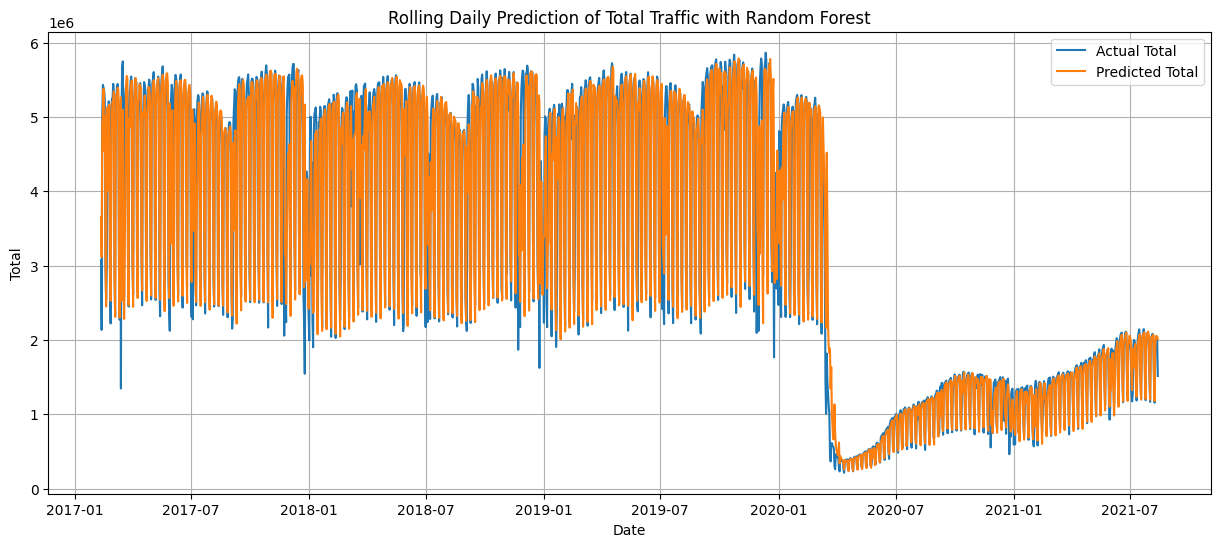

In [24]:
result3 = rolling_daily_prediction_rf(M)
print(result3.head(100))
# Plot example
plt.figure(figsize=(15,6))
plt.plot(result3['Date'], result3['Actual_Total'], label='Actual Total')
plt.plot(result3['Date'], result3['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with Random Forest')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction_prophet(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)

    first_week_end = df['Date'].min() + pd.Timedelta(days=6)
    train_data = df[df['Date'] <= first_week_end].copy()
    test_data = df[df['Date'] > first_week_end].copy()

    predictions_total = []
    actual_total = []
    predictions_netflow = []
    actual_netflow = []
    prediction_dates = []

    for _, row in test_data.iterrows():
        # Prophet for Total
        prophet_total_df = train_data[['Date', 'Total']].rename(columns={'Date': 'ds', 'Total': 'y'})
        model_total = Prophet(daily_seasonality=True)
        model_total.fit(prophet_total_df)

        future_total = pd.DataFrame({'ds': [row['Date']]})
        forecast_total = model_total.predict(future_total)
        total_pred = forecast_total['yhat'].values[0]

        # Prophet for Netflow
        prophet_netflow_df = train_data[['Date', 'Netflow']].rename(columns={'Date': 'ds', 'Netflow': 'y'})
        model_netflow = Prophet(daily_seasonality=True)
        model_netflow.fit(prophet_netflow_df)

        future_netflow = pd.DataFrame({'ds': [row['Date']]})
        forecast_netflow = model_netflow.predict(future_netflow)
        netflow_pred = forecast_netflow['yhat'].values[0]

        # Store predictions and actuals
        predictions_total.append(total_pred)
        actual_total.append(row['Total'])
        predictions_netflow.append(netflow_pred)
        actual_netflow.append(row['Netflow'])
        prediction_dates.append(row['Date'])

        # Update training set with the new row
        train_data = pd.concat([train_data, row.to_frame().T], ignore_index=True)

    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow
    })

    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"Prophet Rolling Total RMSE: {total_rmse:.2f}")
    print(f"Prophet Rolling Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


07:18:29 - cmdstanpy - INFO - Chain [1] start processing
07:18:29 - cmdstanpy - INFO - Chain [1] done processing
07:18:29 - cmdstanpy - INFO - Chain [1] start processing
07:18:29 - cmdstanpy - INFO - Chain [1] done processing
07:18:29 - cmdstanpy - INFO - Chain [1] start processing
07:18:29 - cmdstanpy - INFO - Chain [1] done processing
07:18:30 - cmdstanpy - INFO - Chain [1] start processing
07:18:30 - cmdstanpy - INFO - Chain [1] done processing
07:18:30 - cmdstanpy - INFO - Chain [1] start processing
07:18:30 - cmdstanpy - INFO - Chain [1] done processing
07:18:30 - cmdstanpy - INFO - Chain [1] start processing
07:18:30 - cmdstanpy - INFO - Chain [1] done processing
07:18:30 - cmdstanpy - INFO - Chain [1] start processing
07:18:30 - cmdstanpy - INFO - Chain [1] done processing
07:18:30 - cmdstanpy - INFO - Chain [1] start processing
07:18:30 - cmdstanpy - INFO - Chain [1] done processing
07:18:30 - cmdstanpy - INFO - Chain [1] start processing
07:18:30 - cmdstanpy - INFO - Chain [1]

Prophet Rolling Total RMSE: 750631479219.61
Prophet Rolling Netflow RMSE: 11660.33
         Date  Predicted_Total  Actual_Total  Predicted_Netflow  \
0  2017-02-11     5.503665e+06     3070505.0         619.369675   
1  2017-02-12     4.636736e+06     2135407.0         498.227625   
2  2017-02-13     3.672671e+06     5033368.0         378.076832   
3  2017-02-14     4.197131e+06     5431280.0         449.810821   
4  2017-02-15     4.701046e+06     5389501.0         521.137287   
..        ...              ...           ...                ...   
95 2017-05-17     5.634052e+06     5597936.0         641.031799   
96 2017-05-18     5.546502e+06     5680973.0         633.002264   
97 2017-05-19     5.550138e+06     5462994.0         613.245608   
98 2017-05-20     3.233385e+06     3216882.0         295.992635   
99 2017-05-21     2.712887e+06     2696423.0         259.765722   

    Actual_Netflow  
0       286.336439  
1       192.021830  
2       565.662827  
3       627.966457  
4      

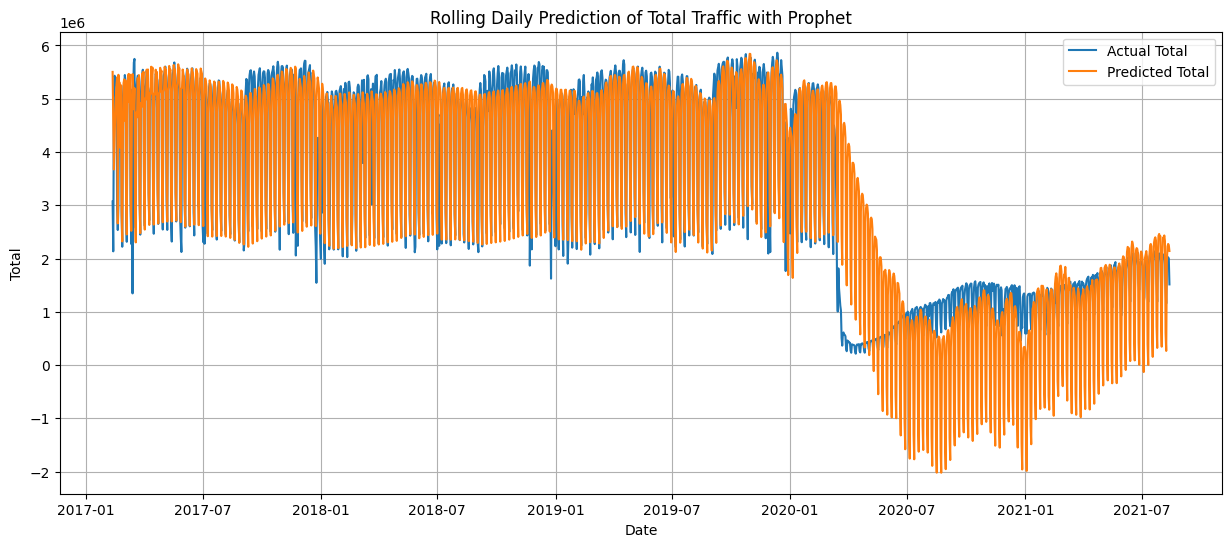

In [27]:
reseults4 = rolling_daily_prediction_prophet(M)
print(reseults4.head(100))
# Plot example
plt.figure(figsize=(15,6))
plt.plot(reseults4['Date'], reseults4['Actual_Total'], label='Actual Total')
plt.plot(reseults4['Date'], reseults4['Predicted_Total'], label='Predicted Total')
plt.title('Rolling Daily Prediction of Total Traffic with Prophet')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction_fixed_window(df, window_size=7):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Netflow']
    Train on a fixed window (default 7 days) of past data, then predict daily in a rolling manner.
    """
    df = df.copy()

    # Create datetime column and sort
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)

    # Create numeric day index
    start_date = df['Date'].min()
    df['day_index'] = (df['Date'] - start_date).dt.days

    predictions_total = []
    predictions_netflow = []
    actual_total = []
    actual_netflow = []
    prediction_dates = []

    # Start predicting from day window_size (e.g., day 7)
    for i in range(window_size, len(df)):
        # Define the fixed-length training window: previous 'window_size' days
        train_data = df.iloc[i - window_size:i]

        # Current test day
        test_row = df.iloc[i]

        X_train = train_data[['day_index']]
        y_train_total = train_data['Total']
        y_train_netflow = train_data['Netflow']

        model_total = LinearRegression().fit(X_train, y_train_total)
        model_netflow = LinearRegression().fit(X_train, y_train_netflow)

        X_test = [[test_row['day_index']]]
        total_pred = model_total.predict(X_test)[0]
        netflow_pred = model_netflow.predict(X_test)[0]

        predictions_total.append(total_pred)
        predictions_netflow.append(netflow_pred)
        actual_total.append(test_row['Total'])
        actual_netflow.append(test_row['Netflow'])
        prediction_dates.append(test_row['Date'])

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow,
    })

    # Calculate RMSE
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"Fixed Window Rolling Prediction Total RMSE: {total_rmse:.2f}")
    print(f"Fixed Window Rolling Prediction Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sgurung/D

Fixed Window Rolling Prediction Total RMSE: 2925484145993.98
Fixed Window Rolling Prediction Netflow RMSE: 49438.55
         Date  Predicted_Total  Actual_Total  Predicted_Netflow  \
0  2017-02-11     5.508034e+06     3070505.0         619.811226   
1  2017-02-12     4.273266e+06     2135407.0         441.030214   
2  2017-02-13     2.289237e+06     5033368.0         189.849449   
3  2017-02-14     3.157533e+06     5431280.0         305.416350   
4  2017-02-15     4.337636e+06     5389501.0         471.635372   
..        ...              ...           ...                ...   
95 2017-05-17     4.050831e+06     5597936.0         449.517158   
96 2017-05-18     5.004948e+06     5680973.0         590.457885   
97 2017-05-19     6.015163e+06     5462994.0         743.722069   
98 2017-05-20     6.846230e+06     3216882.0         843.596495   
99 2017-05-21     5.194884e+06     2696423.0         579.629093   

    Actual_Netflow  
0       286.336439  
1       192.021830  
2       565.6628

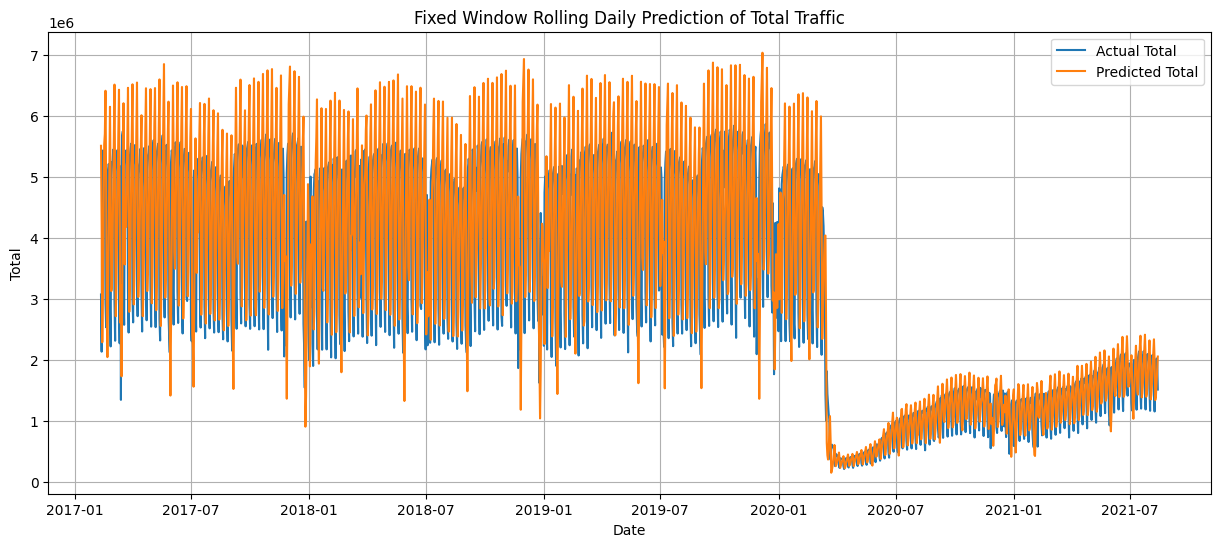

In [ ]:
results5 = rolling_daily_prediction_fixed_window(M, window_size=7)
print(results5.head(100))
# Plot example


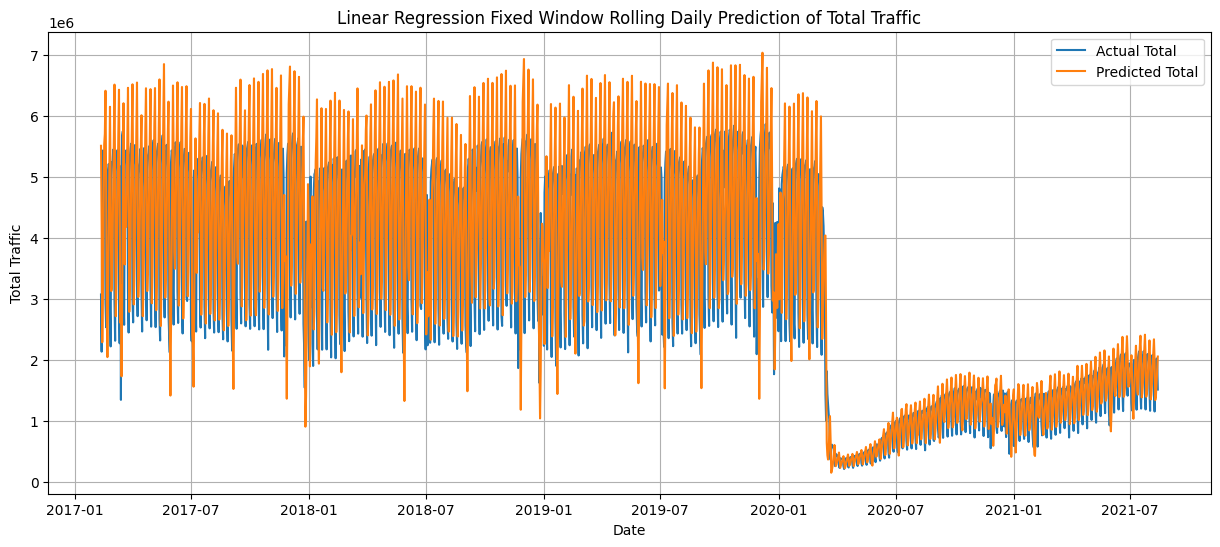

In [46]:
plt.figure(figsize=(15,6))
plt.plot(results5['Date'], results5['Actual_Total'], label='Actual Total')
plt.plot(results5['Date'], results5['Predicted_Total'], label='Predicted Total')
plt.title('Linear Regression Fixed Window Rolling Daily Prediction of Total Traffic')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def rolling_daily_prediction_svr_fixed_window(df, window_size=7):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Netflow']
    Uses SVR with fixed-length rolling window training (default 7 days).
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)
    df['day_index'] = (df['Date'] - df['Date'].min()).dt.days

    predictions_total = []
    predictions_netflow = []
    actual_total = []
    actual_netflow = []
    prediction_dates = []

    # Start predicting from the index at window_size
    for i in range(window_size, len(df)):
        # Select fixed window training data
        train_data = df.iloc[i - window_size:i]

        # Extract features and targets
        X_train = train_data[['day_index']].values
        y_train_total = train_data['Total'].values.reshape(-1, 1)
        y_train_netflow = train_data['Netflow'].values.reshape(-1, 1)

        # Scale features and targets
        scaler_X = StandardScaler()
        scaler_y_total = StandardScaler()
        scaler_y_netflow = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_total_scaled = scaler_y_total.fit_transform(y_train_total).ravel()
        y_train_netflow_scaled = scaler_y_netflow.fit_transform(y_train_netflow).ravel()

        # Train SVR models
        model_total = SVR(kernel='rbf', C=100, epsilon=0.1)
        model_netflow = SVR(kernel='rbf', C=100, epsilon=0.1)

        model_total.fit(X_train_scaled, y_train_total_scaled)
        model_netflow.fit(X_train_scaled, y_train_netflow_scaled)

        # Prepare test data
        test_row = df.iloc[i]
        X_test = [[test_row['day_index']]]
        X_test_scaled = scaler_X.transform(X_test)

        # Predict and inverse transform
        total_pred_scaled = model_total.predict(X_test_scaled)
        netflow_pred_scaled = model_netflow.predict(X_test_scaled)

        total_pred = scaler_y_total.inverse_transform(total_pred_scaled.reshape(-1, 1))[0][0]
        netflow_pred = scaler_y_netflow.inverse_transform(netflow_pred_scaled.reshape(-1, 1))[0][0]

        # Store results
        predictions_total.append(total_pred)
        predictions_netflow.append(netflow_pred)
        actual_total.append(test_row['Total'])
        actual_netflow.append(test_row['Netflow'])
        prediction_dates.append(test_row['Date'])

    # Prepare results DataFrame
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow,
    })

    # Calculate RMSE (you can set squared=False for RMSE)
    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"SVR Fixed Window Rolling Prediction Total RMSE: {total_rmse:.2f}")
    print(f"SVR Fixed Window Rolling Prediction Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


SVR Fixed Window Rolling Prediction Total RMSE: 1734029193761.89
SVR Fixed Window Rolling Prediction Netflow RMSE: 24197.79
         Date  Predicted_Total  Actual_Total  Predicted_Netflow  \
0  2017-02-11     1.044395e+07     3070505.0        1251.035308   
1  2017-02-12    -2.924420e+06     2135407.0        -479.434042   
2  2017-02-13     5.795361e+06     5033368.0         682.849394   
3  2017-02-14     5.764052e+06     5431280.0         638.970869   
4  2017-02-15     4.239398e+06     5389501.0         502.001346   
..        ...              ...           ...                ...   
95 2017-05-17     4.251622e+06     5597936.0         532.990001   
96 2017-05-18     6.101768e+06     5680973.0         722.336663   
97 2017-05-19     5.394190e+06     5462994.0         691.557193   
98 2017-05-20     4.863471e+06     3216882.0         561.094134   
99 2017-05-21     1.825381e+06     2696423.0         117.975545   

    Actual_Netflow  
0       286.336439  
1       192.021830  
2       

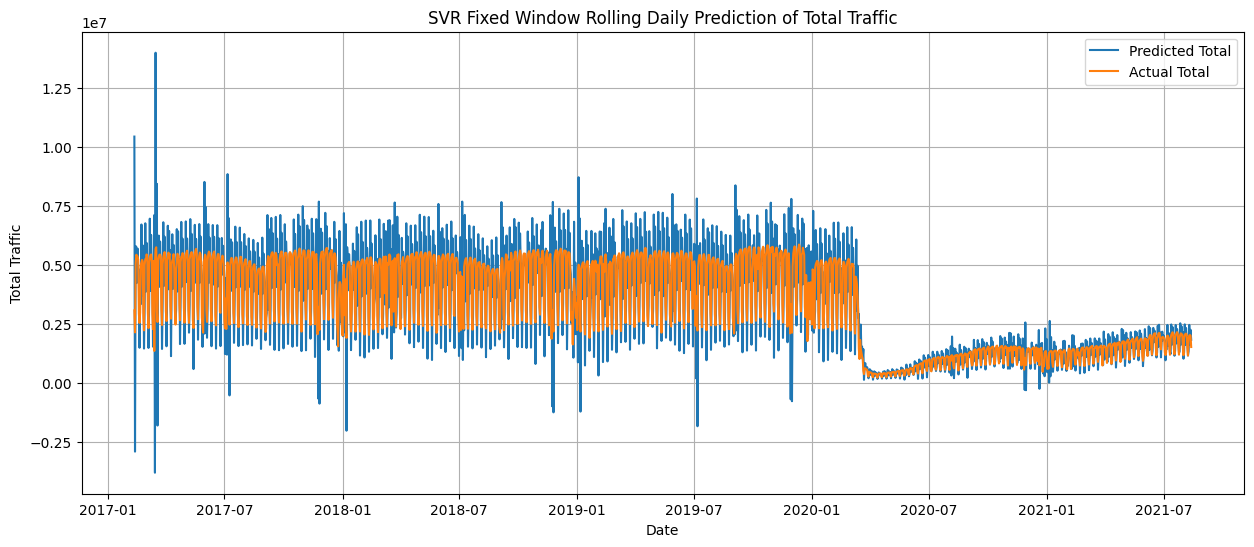

In [43]:
results6 = rolling_daily_prediction_svr_fixed_window(M, window_size=7)
print(results6.head(100))
# Plot example
plt.figure(figsize=(15,6))
plt.plot(results6['Date'], results6['Predicted_Total'], label='Predicted Total')
plt.plot(results6['Date'], results6['Actual_Total'], label='Actual Total')
plt.title('SVR Fixed Window Rolling Daily Prediction of Total Traffic')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction_rf_fixed_window(df, window_size=7):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Netflow']
    Uses RandomForestRegressor with a fixed-length rolling window of 'window_size' days for training.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)
    df['day_index'] = (df['Date'] - df['Date'].min()).dt.days

    # Add temporal features
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    feature_cols = ['day_index', 'day_of_week', 'is_weekend']

    predictions_total = []
    predictions_netflow = []
    actual_total = []
    actual_netflow = []
    prediction_dates = []

    # Start from index = window_size, because before that there is no full window
    for i in range(window_size, len(df)):
        train_data = df.iloc[i - window_size:i]

        X_train = train_data[feature_cols]
        y_train_total = train_data['Total']
        y_train_netflow = train_data['Netflow']

        model_total = RandomForestRegressor(n_estimators=100, random_state=42)
        model_netflow = RandomForestRegressor(n_estimators=100, random_state=42)

        model_total.fit(X_train, y_train_total)
        model_netflow.fit(X_train, y_train_netflow)

        test_row = df.iloc[i]
        X_test = test_row[feature_cols].values.reshape(1, -1)

        total_pred = model_total.predict(X_test)[0]
        netflow_pred = model_netflow.predict(X_test)[0]

        predictions_total.append(total_pred)
        predictions_netflow.append(netflow_pred)
        actual_total.append(test_row['Total'])
        actual_netflow.append(test_row['Netflow'])
        prediction_dates.append(test_row['Date'])

    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow,
    })

    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"Random Forest Fixed Window Rolling Prediction Total RMSE: {total_rmse:.2f}")
    print(f"Random Forest Fixed Window Rolling Prediction Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.wa

Random Forest Fixed Window Rolling Prediction Total RMSE: 401864403429.34
Random Forest Fixed Window Rolling Prediction Netflow RMSE: 6965.07
         Date  Predicted_Total  Actual_Total  Predicted_Netflow  \
0  2017-02-11       3652921.81     3070505.0         370.503775   
1  2017-02-12       3226448.19     2135407.0         313.372546   
2  2017-02-13       4182861.64     5033368.0         464.757209   
3  2017-02-14       4858660.54     5431280.0         543.275495   
4  2017-02-15       5226028.96     5389501.0         603.666531   
..        ...              ...           ...                ...   
95 2017-05-17       5384179.28     5597936.0         620.334208   
96 2017-05-18       5510938.54     5680973.0         651.886409   
97 2017-05-19       5412313.23     5462994.0         650.443932   
98 2017-05-20       3854208.84     3216882.0         397.904995   
99 2017-05-21       3207092.41     2696423.0         320.387961   

    Actual_Netflow  
0       286.336439  
1       192

/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sgurung/Desktop/Concept Drift in Data Science/Project/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


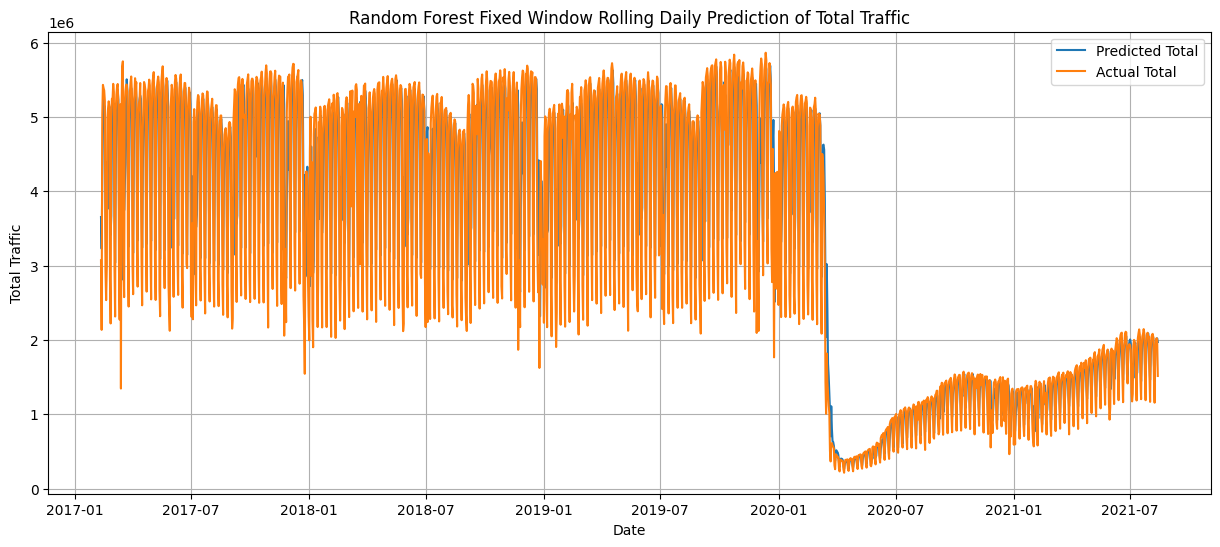

In [ ]:
results7 = rolling_daily_prediction_rf_fixed_window(M, window_size=7)
print(results7.head(100))
# Plot example

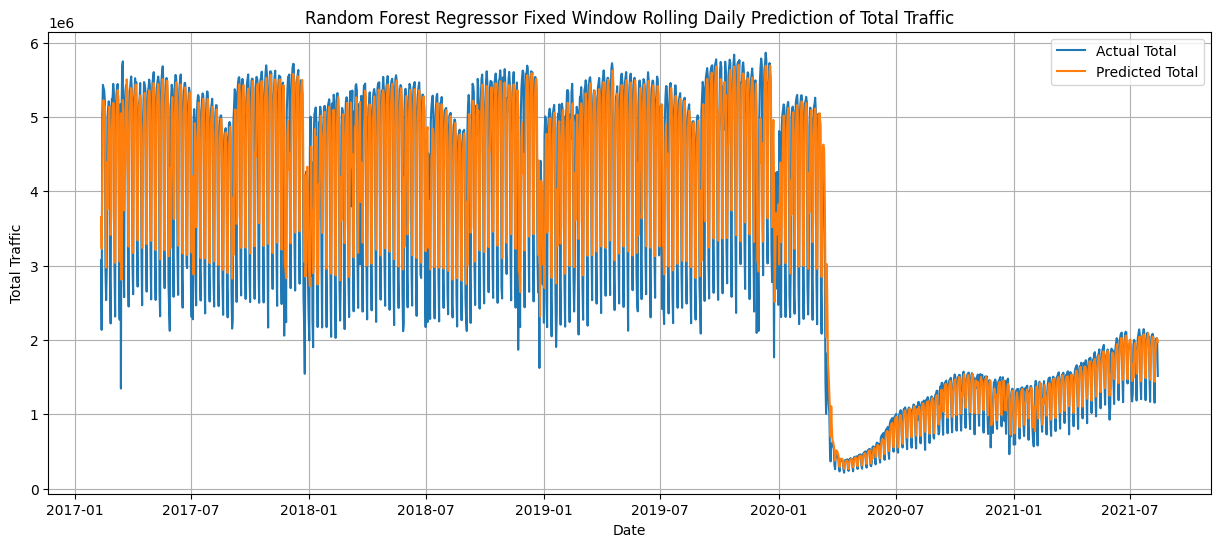

In [44]:
plt.figure(figsize=(15,6))
plt.plot(results7['Date'], results7['Actual_Total'], label='Actual Total')
plt.plot(results7['Date'], results7['Predicted_Total'], label='Predicted Total')
plt.title('Random Forest Regressor Fixed Window Rolling Daily Prediction of Total Traffic')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_daily_prediction_prophet_fixed_window(df, window_size=7):
    """
    df must have columns: ['Year', 'Month', 'Day', 'Total', 'Netflow']
    Uses Prophet with a fixed-length rolling window of 'window_size' days for training.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date').reset_index(drop=True)

    predictions_total = []
    actual_total = []
    predictions_netflow = []
    actual_netflow = []
    prediction_dates = []

    # Start predicting once we have a full window of training data
    for i in range(window_size, len(df)):
        train_data = df.iloc[i - window_size:i]
        test_row = df.iloc[i]

        # Prophet model for Total
        prophet_total_df = train_data[['Date', 'Total']].rename(columns={'Date': 'ds', 'Total': 'y'})
        model_total = Prophet(daily_seasonality=True)
        model_total.fit(prophet_total_df)

        future_total = pd.DataFrame({'ds': [test_row['Date']]})
        forecast_total = model_total.predict(future_total)
        total_pred = forecast_total['yhat'].values[0]

        # Prophet model for Netflow
        prophet_netflow_df = train_data[['Date', 'Netflow']].rename(columns={'Date': 'ds', 'Netflow': 'y'})
        model_netflow = Prophet(daily_seasonality=True)
        model_netflow.fit(prophet_netflow_df)

        future_netflow = pd.DataFrame({'ds': [test_row['Date']]})
        forecast_netflow = model_netflow.predict(future_netflow)
        netflow_pred = forecast_netflow['yhat'].values[0]

        # Store predictions and actuals
        predictions_total.append(total_pred)
        actual_total.append(test_row['Total'])
        predictions_netflow.append(netflow_pred)
        actual_netflow.append(test_row['Netflow'])
        prediction_dates.append(test_row['Date'])

    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Predicted_Total': predictions_total,
        'Actual_Total': actual_total,
        'Predicted_Netflow': predictions_netflow,
        'Actual_Netflow': actual_netflow
    })

    total_rmse = mean_squared_error(results_df['Actual_Total'], results_df['Predicted_Total'])
    netflow_rmse = mean_squared_error(results_df['Actual_Netflow'], results_df['Predicted_Netflow'])

    print(f"Prophet Fixed Window Rolling Prediction Total RMSE: {total_rmse:.2f}")
    print(f"Prophet Fixed Window Rolling Prediction Netflow RMSE: {netflow_rmse:.2f}")

    return results_df


07:42:44 - cmdstanpy - INFO - Chain [1] start processing
07:42:44 - cmdstanpy - INFO - Chain [1] done processing
07:42:44 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1] done processing
07:42:45 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1] done processing
07:42:45 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1] done processing
07:42:45 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1] done processing
07:42:45 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1] done processing
07:42:45 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1] done processing
07:42:45 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1] done processing
07:42:45 - cmdstanpy - INFO - Chain [1] start processing
07:42:45 - cmdstanpy - INFO - Chain [1]

Prophet Fixed Window Rolling Prediction Total RMSE: 2919151679966.18
Prophet Fixed Window Rolling Prediction Netflow RMSE: 49365.66
         Date  Predicted_Total  Actual_Total  Predicted_Netflow  \
0  2017-02-11     5.503665e+06     3070505.0         619.369675   
1  2017-02-12     4.267432e+06     2135407.0         441.132845   
2  2017-02-13     2.286220e+06     5033368.0         190.230498   
3  2017-02-14     3.146668e+06     5431280.0         304.779989   
4  2017-02-15     4.331699e+06     5389501.0         471.263582   
..        ...              ...           ...                ...   
95 2017-05-17     4.052329e+06     5597936.0         448.470260   
96 2017-05-18     4.999744e+06     5680973.0         590.577119   
97 2017-05-19     6.013200e+06     5462994.0         743.255977   
98 2017-05-20     6.844062e+06     3216882.0         843.368564   
99 2017-05-21     5.193876e+06     2696423.0         579.493180   

    Actual_Netflow  
0       286.336439  
1       192.021830  


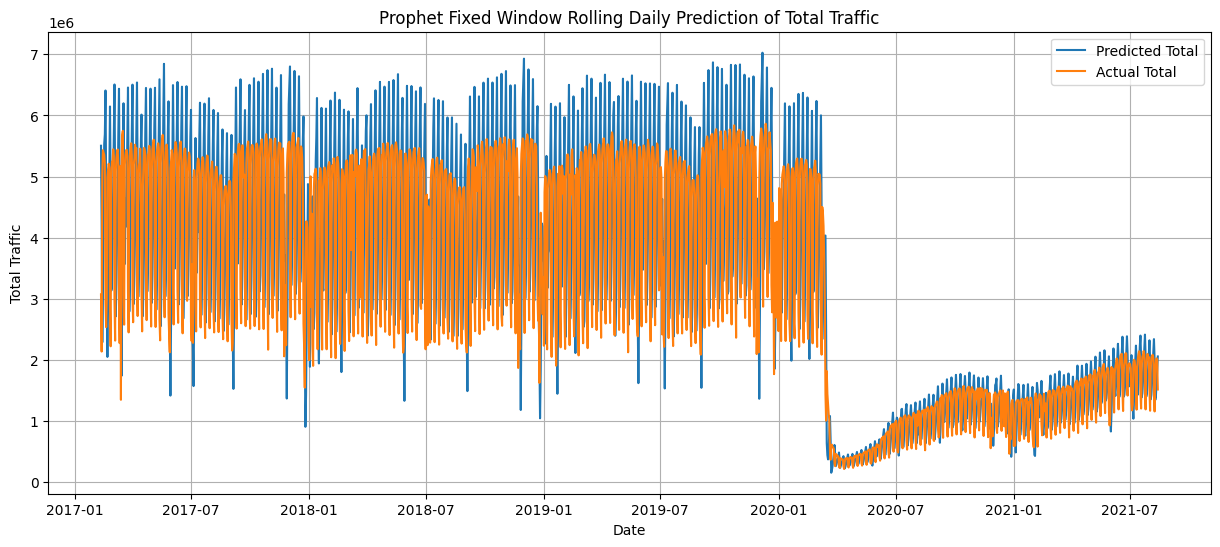

In [39]:
results8 = rolling_daily_prediction_prophet_fixed_window(M, window_size=7)
print(results8.head(100))
# Plot example
plt.figure(figsize=(15,6))
plt.plot(results8['Date'], results8['Predicted_Total'], label='Predicted Total')
plt.plot(results8['Date'], results8['Actual_Total'], label='Actual Total')
plt.title('Prophet Fixed Window Rolling Daily Prediction of Total Traffic')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend()
plt.grid(True)
plt.show()